In [106]:
import sys
sys.path.append("../")
import os
import multiprocessing
from multiprocessing import Pool, cpu_count
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [107]:
THREAD_COUND=max(1,int(cpu_count()-2))
DATA_FOLDER="/media/julian/ex1ext4_1/temp/"
PROPVEC_FOLDER=os.path.join(DATA_FOLDER,"prop_vecs")
LOG_FOLDER=os.path.join(DATA_FOLDER,"logs")
GLF_PARAMS_FILE = os.path.join(DATA_FOLDER,"glf_params.csv")
os.makedirs(LOG_FOLDER,exist_ok=True)
os.makedirs(PROPVEC_FOLDER,exist_ok=True)

logger = logging.getLogger("ecdf_4")
logger.setLevel(logging.DEBUG)
for h in list(logger.handlers):
    logger.removeHandler(h)

fh = logging.FileHandler(os.path.join(LOG_FOLDER,"ecdf_4.log"))
fh.setLevel(logging.DEBUG)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
logger.addHandler(ch)

In [108]:
data_files=np.array([os.path.join(PROPVEC_FOLDER,f)for f in os.listdir(PROPVEC_FOLDER) if f.endswith(".npy")])

In [291]:
import seaborn as sns
def ecdf(x,remove_steps=False,remove_duplicates=False,cutter_lower=0.001,cutter_upper=0.001):
    x=x[~(np.isinf(x) | np.isneginf(x) | np.isnan(x))]
    xs = np.sort(x)
    xs=xs[int(xs.size*cutter_lower):-int(xs.size*cutter_upper)]
    ys = np.linspace(0, len(xs),len(xs))/float(len(xs))
    if remove_steps:
        xsu,uidx,counts = np.unique(xs,return_index=True,return_counts =True)

        xs=xsu
        ys=ys[uidx]
        if not remove_duplicates:
            xs=np.repeat(xs, counts)
            ys=np.repeat(ys, counts)
#            ys=ys[ridx]
            #xs=xs[ridx]
   #         for xi,idx in zip(xsu,uidx):
   #             ys[xs==xi]=ys[idx]
    return xs, ys

def generate_histo(data,name):
    #currently only 1 dim
    
    
    df=data.flatten()
    x=df
    
    mmin,mmax,mmean,msig=x.min(),x.max(),x.mean(),x.std()
    
    plt.hist(x,bins="sturges")
    plt.title('{} histogram'.format(name))
    plt.show()
    plt.close()
    
    fig, ax = plt.subplots(figsize=(12,4),nrows = 1,ncols = 3)
    
    y=(x-mmin)/(mmax-mmin)
    ax[0].hexbin(x=x, y=y,gridsize=20)
    ax[0].title.set_text('density min-max normalization')
    
    y=(x-mmean)/(mmax-mmin)
    ax[1].hexbin(x=x, y=y,gridsize=20)
    ax[1].title.set_text('density mean normalization')
    
    y=(x-mmean)/msig
    ax[2].hexbin(x=x, y=y,gridsize=20)
    ax[2].title.set_text('density Z-score normalization')
    plt.title('{} linear normalizations'.format(name))
    #plt.yscale('log')
    plt.show()
    plt.close()
#    print(name,data.min(),data.max(),data.shape)

In [292]:
try:
    glf_params = pd.read_csv(GLF_PARAMS_FILE,index_col=0)
except Exception as e:
    glf_params=pd.DataFrame(columns=["Q","B","M","v","loss"])
glf_params

,Q,B,M,v,loss
molecule_num_atoms,0.006598,0.141329,39.231609,0.076392,0.000028
molecule_slog_p_vsa11,0.005044,0.478458,10.953826,0.232559,0.000756
molecule_peoe_vsa11,0.003375,0.245265,15.349249,0.111637,0.000559
molecule_fr_aryl_methyl,0.002976,1.992162,1.294743,0.013743,0.000262
molecule_chi2n,0.009911,0.535669,9.949143,0.113947,0.000066
...,...,...,...,...,...
molecule_whim__59,0.713600,11.344202,-0.070296,0.056371,0.000378
molecule_whim__60,0.904287,64.205345,0.090797,0.004104,0.000190
molecule_whim__61,0.903726,64.065155,0.090421,0.004020,0.000193
molecule_whim__62,0.905116,62.565304,0.093856,0.004508,0.001783


In [296]:
import torch
from torch import nn

class GenLogFuncReg(nn.Module):
    def __init__(self,Q=1,B=0.1,M=0.1,v=0.1):
        super().__init__()
        self.Q = nn.Parameter(torch.Tensor([Q]))  # nn.Parameter is a Tensor that's a module parameter.
        self.B = nn.Parameter(torch.Tensor([B]))  # nn.Parameter is a Tensor that's a module parameter.
        self.M = nn.Parameter(torch.Tensor([M]))  # nn.Parameter is a Tensor that's a module parameter.
        self.v = nn.Parameter(torch.Tensor([v]))  # nn.Parameter is a Tensor that's a module parameter.
        self.reset_parameters()
        self._clean_parameter()

    def glf_parameters(self):
        return  self.Q.data.item(), self.B.data.item(), self.M.data.item(), self.v.data.item()

    def reset_parameters(self):
        return
        nn.init.normal_(self.Q,1)
        nn.init.normal_(self.B,1)
        nn.init.normal_(self.M,1)
        nn.init.normal_(self.v,1)
        self._clean_parameter()
    
    def _clean_parameter(self):
        self.v.data.clamp_(min=1e-16,max=2**32-1)
        self.B.data.clamp_(min=1e-16,max=2**32-1)
        self.Q.data.clamp_(min=1e-16,max=2**32-1)

        
    def forward(self, x):
        Q,B,M,v = self.Q,self.B,self.M,self.v
        return 1/((1+Q*torch.exp(-B*(x-M)))**(1/v))
        return GenLogFunc.apply(x,self.Q,self.B,self.M,self.v)
    
    def predict(self,x):
        _np=False
        if isinstance(x,np.ndarray):
            _np=True
            x = torch.from_numpy(x).float()
        y=self(x)
        if _np:
            y=y.detach().numpy()
        return y
    
    def fit(self,x,y,lr=0.1):
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        ##print(x,y)
        if isinstance(x,np.ndarray):
            x=torch.from_numpy(x).float()
        if isinstance(y,np.ndarray):
            y=torch.from_numpy(y).float()

        pre_loss=None
        d0=100
        _d=d0

        best_loss=criterion(self(x), y)
        best_vals={
            "Q":self.Q.data,
            "M":self.M.data,
            "B":self.B.data,
            "v":self.v.data,
        }
        best_epoch=-1
        for epoch in range(100000):  # loop over the dataset multiple times
            print(epoch,end="\r")
            optimizer.zero_grad()
            outputs = self(x)
            loss = criterion(outputs, y)
            
            if epoch-best_epoch>d0:
                break
            
            if loss<best_loss-1e-6:
                best_loss=loss
                best_epoch = epoch
                print(best_epoch,best_loss,end="\r")
                best_vals = {
                    "Q":self.Q.data,
                    "M":self.M.data,
                    "B":self.B.data,
                    "v":self.v.data,
                }
                
            loss.backward()
            if not all(torch.isfinite(param.grad).all()  for name, param in self.named_parameters()):
                break

            optimizer.step()
            self._clean_parameter()
        self.Q.data=best_vals["Q"]
        self.M.data=best_vals["M"]
        self.B.data=best_vals["B"]
        self.v.data=best_vals["v"]
        #print(best_epoch,epoch)
        return best_loss.item()
    
def reg_nn(x,y):
    xmin=np.min(x)
    xmax=np.max(x)
    xmed=np.median(x)

    M=xmed
    if M==0:
        M=0.1
    qinia=lambda Q0: 1/(1+Q0*(np.exp((np.log((1+Q0)**np.log2(10) - 1)-np.log(Q0))*(xmax-xmed)/(xmin-xmed))))
    qinib=lambda Q0: 0.9**(np.log2(1+Q0))
    
    
    r=1000
    qx=np.linspace(-r,r,1000)
    print(xmin,xmed,xmax)
    for i in range(5):
        qy=qinia(qx)-qinib(qx)
        qm0=qm1=qm2=np.nanargmin(qy)
        if qm0>0:
            qm0=qm1-1
        if qm2<len(qx)-1:
            qm2=qm1+1
        Q=qx[qm1]
        qx=np.linspace(qx[qm0],qx[qm2],1000)

    Q=1
    v=np.log2(1+Q)
    B=(np.log((1+Q)**np.log2(10) - 1)-np.log(Q))/(xmed-xmin)
    #print(Q,B,M,v)
    net = GenLogFuncReg(
        Q=Q,
        B=B,
        M=M,
        v=v
    )
    #print(net.glf_parameters())
    r=.99
  #  print(net.glf_parameters())
    plot=False
    if plot:
        plt.plot(x,y)
        plt.plot(x,net.predict(x))
        plt.title("prefit")
        plt.show()
        plt.close()
    lr=0.001
    for s,k,lr in [(0,0.9,lr),(0,0.95,lr),
                   (0,0.99,lr),(0.0,0.99,lr/10),(0.00,0.999,lr/10),(0.00,1,lr/10)
                  ]:
            yl= (y<=k)#&(y>=s)
            loss=net.fit(x[yl],y[yl],lr=lr)
            if plot:
                plt.plot(x[yl],y[yl])
                plt.plot(x[yl],net.predict(x[yl]))
                plt.title("fitsampl")
                plt.show()
                plt.close()
                plt.plot(x,y)
                plt.plot(x,net.predict(x))
                plt.title("fit")
                plt.show()
                plt.close()
#            print(k,lr,loss,net.glf_parameters())
 #           plt.plot(xs,ys,label=i)
 #           plt.plot(xs,net.predict(xs),label=i)
 #           plt.show()
 #           plt.close()
    return net.glf_parameters()

from scipy.interpolate import interp1d
def generate_ecdf(data,name,glf_params,plot=True):
    if name in glf_params.index and not plot:
        return glf_params
    xf,yf=ecdf(data.flatten())
    #plt.plot(xf[yf<0.99],yf[yf<0.99])
    #plt.show()
    #plt.close()
    #print(xf.shape)
    #x,y=ecdf(data.flatten(),remove_steps=True,remove_duplicates=True)
    #print(xf.min(),xf[yf<0.95].max(),xf[yf>=0.95].min(),xf.max())
    N=1_000_000
    xl=np.concatenate([
        np.linspace(xf.min(),xf[yf<0.05].max(),int(0.05*N)),
        np.linspace(xf[yf>=0.05].min(),xf[yf<0.90].max(),int(0.90*N)),
        np.linspace(xf[yf>=0.95].min(),xf.max(),int(0.05*N))
    ])
   # x,y=ecdf(data.flatten(),remove_steps=True,remove_duplicates=True)
   # plt.plot(x)
   # plt.show()
    #plt.close()
    if xf.max()>100_000:
        xl=np.concatenate([
        np.linspace(np.log(xf.min()),np.log(xf[yf<0.05].max()),int(0.05*N)),
        np.linspace(np.log(xf[yf>=0.05].min()),np.log(xf[yf<0.95].max()),int(0.95*N)),
        np.linspace(np.log(xf[yf>=0.95].min()),np.log(xf.max()),int(0.05*N))
        ])
        xl=np.exp(xl)
        plt.plot(xl)
        plt.show()
        plt.close()
    #print("xl.shape",xl.shape)
    
    x,y=ecdf(data.flatten(),remove_steps=True,remove_duplicates=True)
    #print(x.shape)
    if x.size<=1:
        return glf_params
    ecdf_u = interp1d(x,y,fill_value="extrapolate")
    yxl = ecdf_u(xl)
    #plt.plot(xl,yxl)
    #print("xl[np.isnan(yxl)]",xl[np.isnan(yxl)])
    #plt.show()
    #plt.close()
    #print(yxl.shape)
    if name not in glf_params.index:
        dyxl=np.zeros_like(yxl)
        dyxl[1:]=np.abs(np.diff(yxl))
        dyxl[0]=dyxl[1]
        ryxl=dyxl/dyxl[dyxl>0].min() - 1
        ryxl/=ryxl.sum()
        ryxl[ryxl<0]=0
        ryxl*=100_000
        ryxl=np.ceil(ryxl).astype(int)
        ryxl[ryxl<=0]=1
        #plt.plot(xl,ryxl)
        #plt.show()
        #plt.close()
        print("reg",name)
        #Q,B,M,v=reg_nn(xl,ecdf_u(xl))
        Q,B,M,v=reg_nn(np.repeat(xl,ryxl),np.repeat(yxl,ryxl))
        glf_params=glf_params.append(pd.Series(name=name))
        #display(glf_params.index)
        glf_params.loc[name,"Q"]=Q
        glf_params.loc[name,"B"]=B
        glf_params.loc[name,"M"]=M
        glf_params.loc[name,"v"]=v
        glfy=glf(x,Q,B,M,v)
        glf_params.loc[name,"loss"]=((glfy-y)**2).mean()
        #glf_params.loc[name,"loss_.01_.99"]=((glfy[y_01_99]-ys[y_01_99])**2).mean()
 
    if plot:   
        glfy=glf(xl, glf_params.loc[name,"Q"], glf_params.loc[name,"B"], glf_params.loc[name,"M"], glf_params.loc[name,"v"])

        plt.plot(xf,yf,label="ecdf")
        #plt.plot(xl,yxl,label="unique min ecdf")
        plt.plot(xl,glfy,label="fitted ecdf")
        plt.title("{} ecdf (loss={})".format(name,glf_params.loc[name,"loss"]))
        plt.legend()
        plt.show()
        plt.close()
        
        #plt.plot(xf[yf<0.95],yf[yf<0.95],label="ecdf 95%")
        #plt.plot(xl[glfy<0.99],glfy[glfy<0.99],label="fitted ecdf 95%")
        #plt.title("{} ecdf 95% (loss={})".format(name,glf_params.loc[name,"loss"]))
        #plt.legend()
        #plt.show()
        #plt.close()
        #yf=glf(xf, glf_params.loc[name,"Q"], glf_params.loc[name,"B"], glf_params.loc[name,"M"], glf_params.loc[name,"v"])
        #plt.hexbin(x=xf, y=yf,gridsize=20)
        #plt.title('{} ecdf normalization'.format(name))
        #plt.show()
        #plt.close()
    return glf_params

In [297]:
def glf_generator(Q,B,M,v):
    def _glf(x):
        return 1/((1+Q*np.exp(-B*(x-M)))**(1/v))
    return _glf

def glf(x,Q,B,M,v):
    return glf_generator(Q,B,M,v)(x)

molecule_crippen_descriptors (1957547, 2)
molecule_whim (1957547, 114)
molecule_morse (1957547, 224)
molecule_smr_vsa8 (1957547, 1)
molecule_getaway (1957547, 273)
molecule_autocorr3d (1957547, 80)
molecule_get_usrcat (1957547, 60)
molecule_slog_p_vsa9 (1957547, 1)
molecule_fr_prisulfonamd (1957547, 1)
molecule_get_usr (1957547, 12)
molecule_bcut2d (1957547, 8)
molecule_autocorr2d (1957547, 192)
molecule_rdf (1957547, 210)
reg molecule_rdf__6
0.0010000000474974513 5.433774871758237 55.034000396728516


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


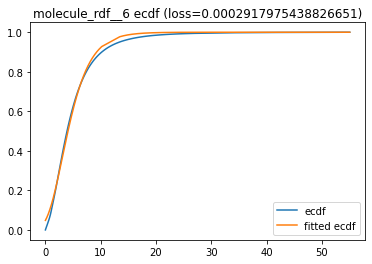

reg molecule_rdf__7
0.0 8.693713641092486 88.66400146484375


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


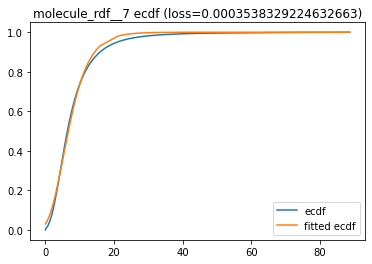

reg molecule_rdf__8
0.0 10.131317857821521 103.625


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


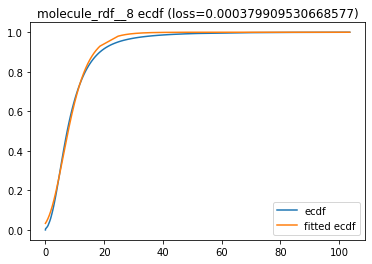

reg molecule_rdf__9
0.0 7.473169451088845 104.1719970703125


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


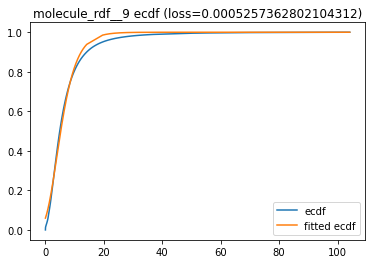

reg molecule_rdf__10
0.0 8.078989602004132 118.27899932861328


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


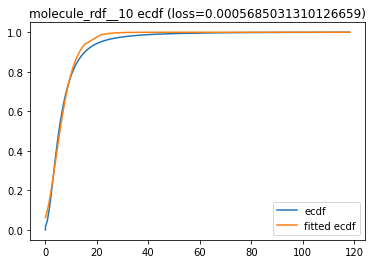

reg molecule_rdf__11
0.0 8.628150277051885 127.93599700927734


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


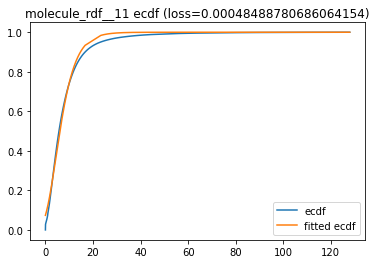

reg molecule_rdf__12
0.0 6.725361378417332 128.82899475097656


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


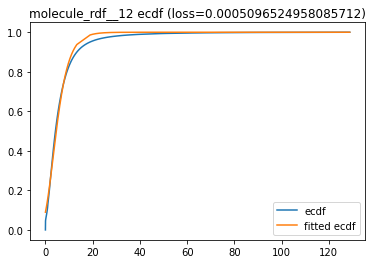

reg molecule_rdf__13
0.0 5.985260041761964 131.67300415039062
30 tensor(0.0162, grad_fn=<MseLossBackward>)

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


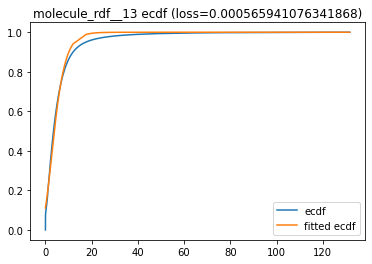

reg molecule_rdf__14
0.0 5.38141787110395 135.3249969482422


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


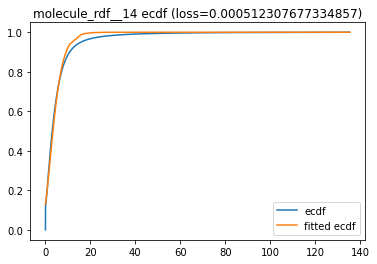

reg molecule_rdf__15
0.0 5.35185053812454 138.73500061035156


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


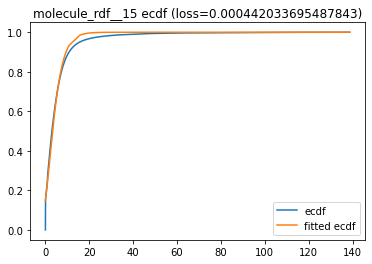

reg molecule_rdf__16
0.0 4.597677049719291 138.42799377441406


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


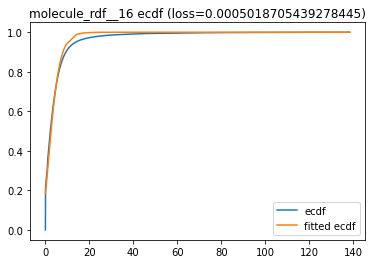

reg molecule_rdf__17
0.0 3.9436239652251595 136.052001953125


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


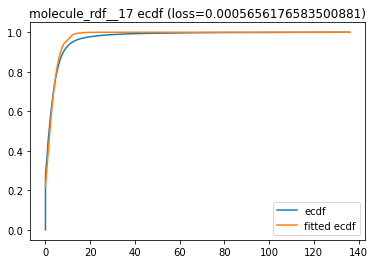

reg molecule_rdf__18
0.0 3.558804194089748 133.447998046875


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


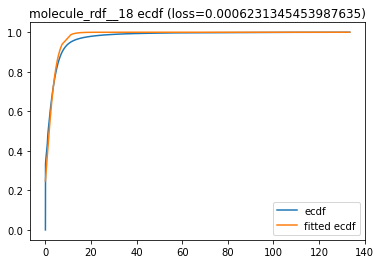

reg molecule_rdf__19
0.0 3.1961997560716795 128.86000061035156


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


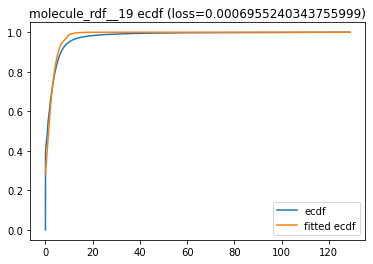

reg molecule_rdf__20
0.0 2.857585842916629 124.25700378417969


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


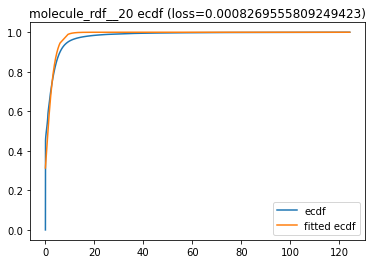

reg molecule_rdf__21
0.0 2.411294442568071 118.08799743652344


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


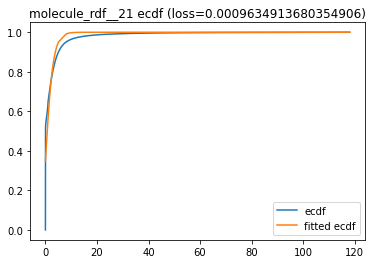

reg molecule_rdf__22
0.0 2.0837931547191313 112.12000274658203


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


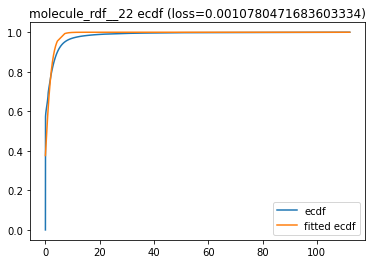

reg molecule_rdf__23
0.0 1.8179340987142618 105.57099914550781


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


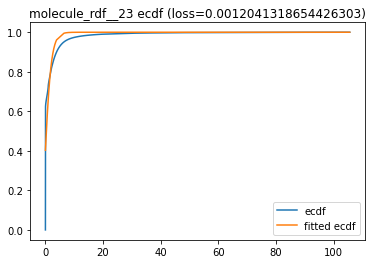

reg molecule_rdf__24
0.0 1.5473589917629318 97.56600189208984


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


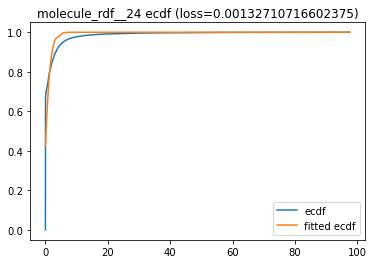

reg molecule_rdf__25
0.0 1.2472122008784936 89.0719985961914


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


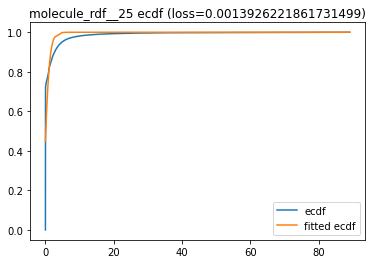

reg molecule_rdf__26
0.0 0.9772117170365687 81.54000091552734


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


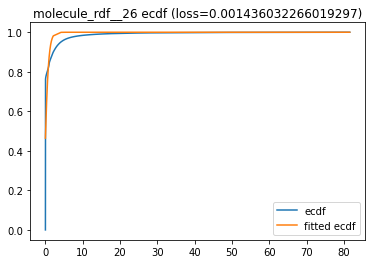

reg molecule_rdf__27
0.0 0.7786385996366854 73.2509994506836


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


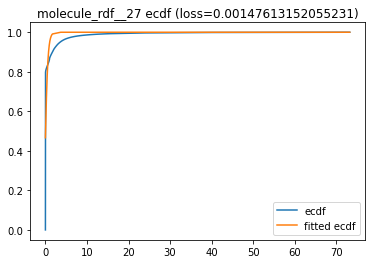

reg molecule_rdf__28
0.0 0.5513588811220091 66.57499694824219


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


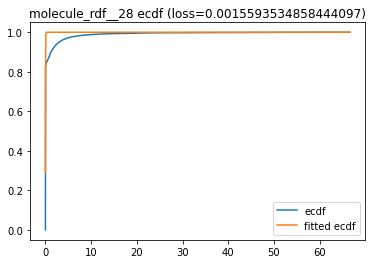

reg molecule_rdf__29
0.0 0.3855565001186187 59.02000045776367


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


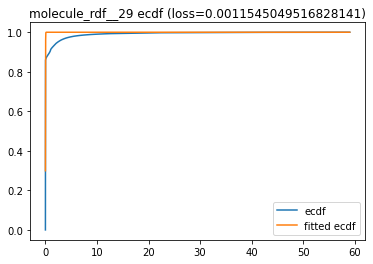

reg molecule_rdf__30
0.0 0.01610607114169561 0.3370000123977661


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


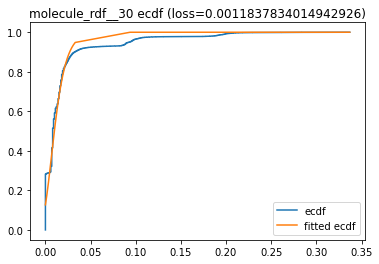

reg molecule_rdf__31
1.9240000247955322 14.973727685165915 90.12100219726562


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


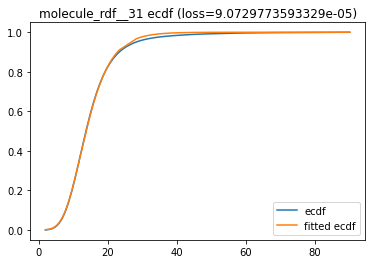

reg molecule_rdf__32
0.0 0.6203902122397287 13.298999786376953


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


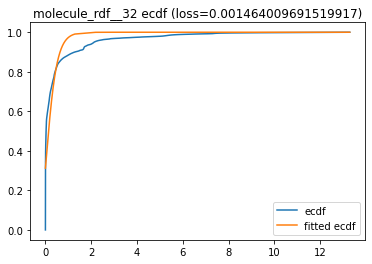

reg molecule_rdf__33
1.527999997138977 21.47300544822498 122.19599914550781


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


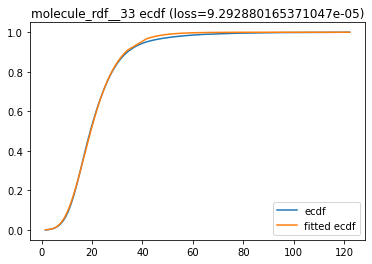

reg molecule_rdf__34
0.003000000026077032 6.769673165100743 54.68899917602539


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


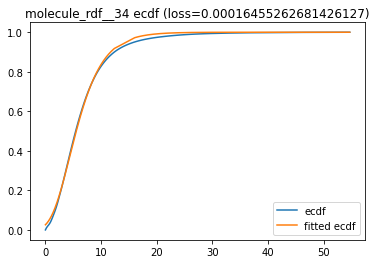

reg molecule_rdf__35
0.009999999776482582 7.996416676503871 70.83300018310547


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


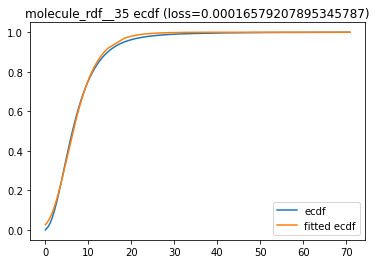

reg molecule_rdf__36
0.0010000000474974513 8.603695087469742 75.78099822998047
28 tensor(0.0112, grad_fn=<MseLossBackward>)

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


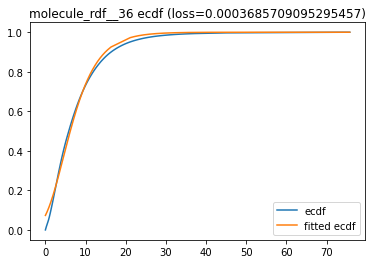

reg molecule_rdf__37
0.0 11.131009199996765 111.06199645996094


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


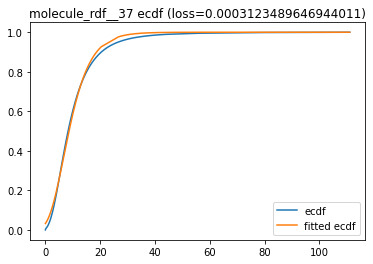

reg molecule_rdf__38
0.0 12.418396330045434 126.4749984741211


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


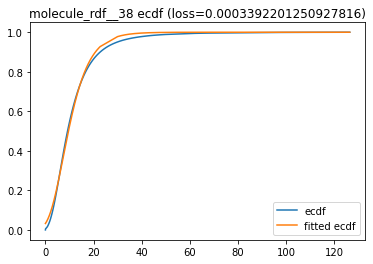

reg molecule_rdf__39
0.0 9.579659705126488 129.6840057373047


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


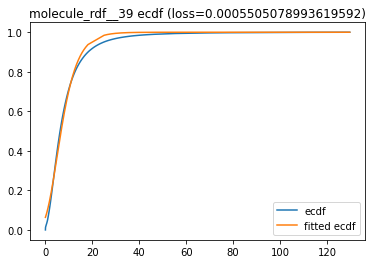

reg molecule_rdf__40
0.0 10.190823561210442 145.39199829101562


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


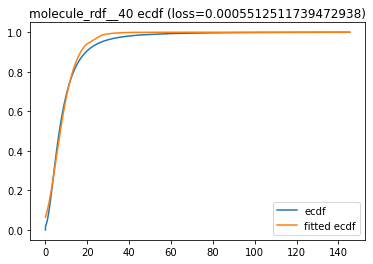

reg molecule_rdf__41
0.0 10.741915556047063 156.13800048828125


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


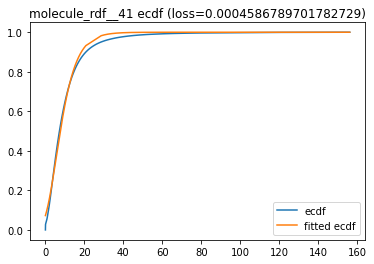

reg molecule_rdf__42
0.0 8.733815352868765 158.81399536132812


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


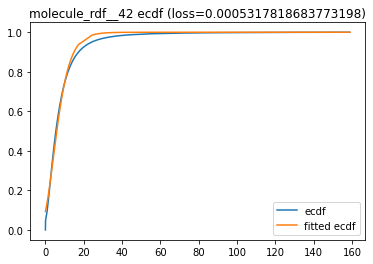

reg molecule_rdf__43
0.0 7.638534311006074 160.7830047607422


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


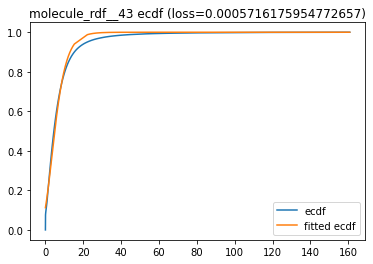

reg molecule_rdf__44
0.0 6.893502132967729 164.4340057373047
30 tensor(0.0181, grad_fn=<MseLossBackward>)

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


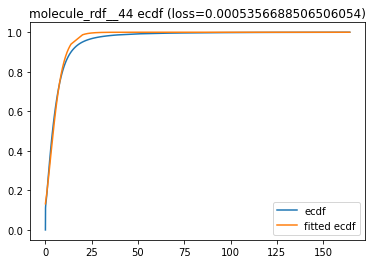

reg molecule_rdf__45
0.0 6.789965930729776 168.8939971923828


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


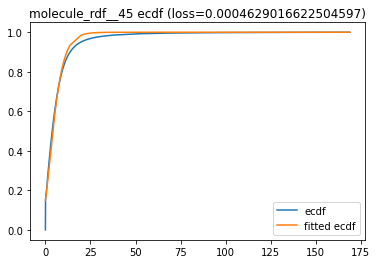

reg molecule_rdf__46
0.0 5.972590422609091 168.31199645996094


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


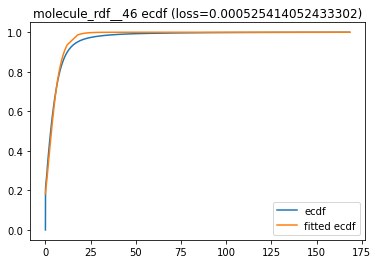

reg molecule_rdf__47
0.0 5.098177690061219 165.18299865722656


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


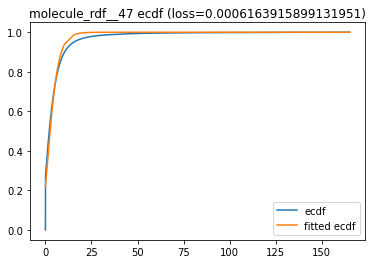

reg molecule_rdf__48
0.0 4.594651140044439 162.5050048828125
26 tensor(0.0380, grad_fn=<MseLossBackward>)

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


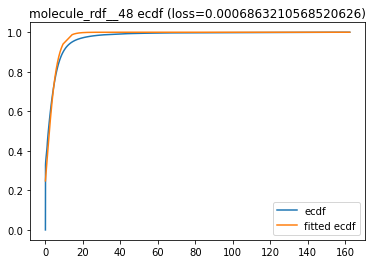

reg molecule_rdf__49
0.0 4.120113482602029 156.2949981689453


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


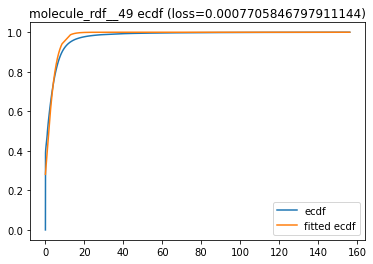

reg molecule_rdf__50
0.0 3.695625989101958 150.02099609375


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


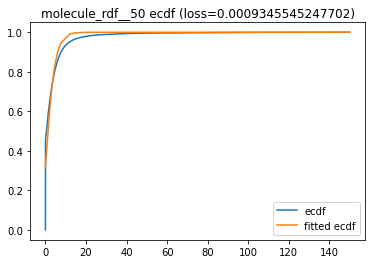

reg molecule_rdf__51
0.0 3.120798827493987 142.677001953125


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


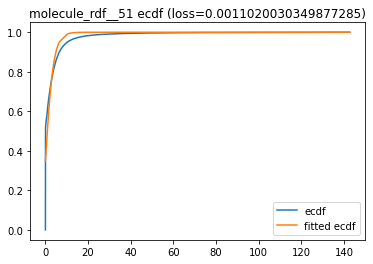

reg molecule_rdf__52
0.0 2.6880872860419105 135.1529998779297
28 tensor(0.0786, grad_fn=<MseLossBackward>)

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


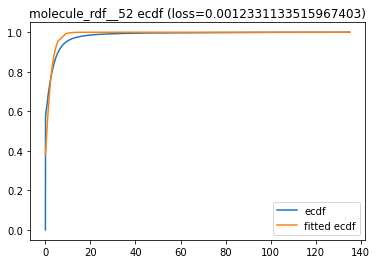

reg molecule_rdf__53
0.0 2.350123366076108 126.85800170898438


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


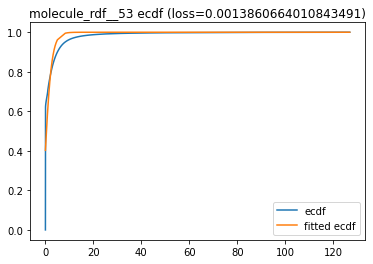

reg molecule_rdf__54
0.0 1.9969886583427634 117.53099822998047


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


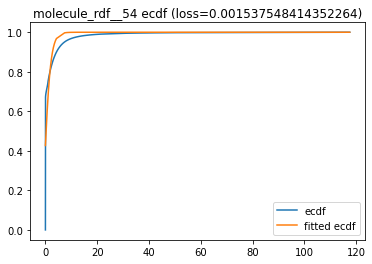

reg molecule_rdf__55
0.0 1.6015028868540033 107.64299774169922


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


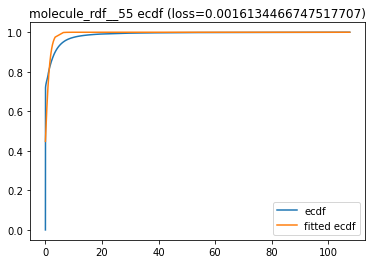

reg molecule_rdf__56
0.0 1.265456291719115 97.25499725341797


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


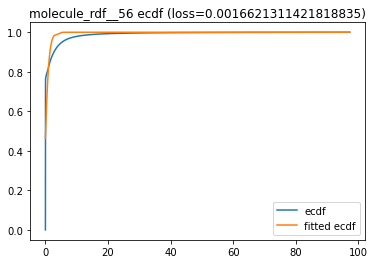

reg molecule_rdf__57
0.0 0.9938279437443998 87.93099975585938


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


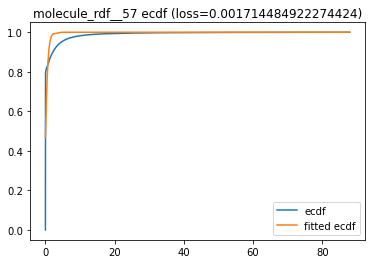

reg molecule_rdf__58
0.0 0.7221362487898818 78.8280029296875


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


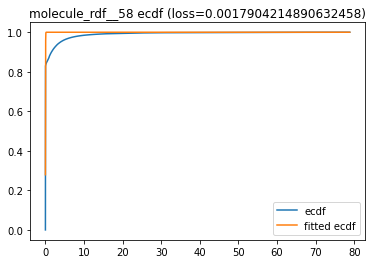

reg molecule_rdf__59
0.0 0.45505455937336775 70.18699645996094


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


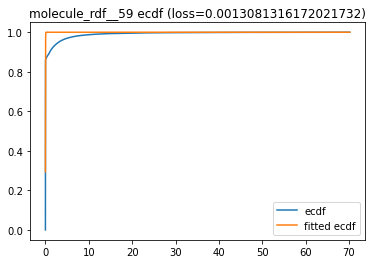

reg molecule_rdf__60
0.0 0.009574268663548036 0.32499998807907104


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


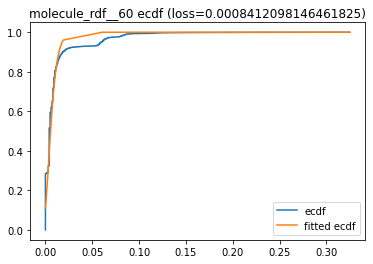

reg molecule_rdf__61
1.340999960899353 12.844690833495497 78.74299621582031


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


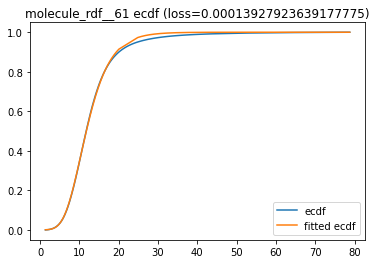

reg molecule_rdf__62
0.0 0.21927568401942746 3.5380001068115234


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


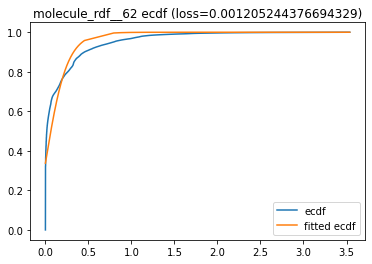

reg molecule_rdf__63
0.8949999809265137 18.026693944330617 104.86100006103516


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


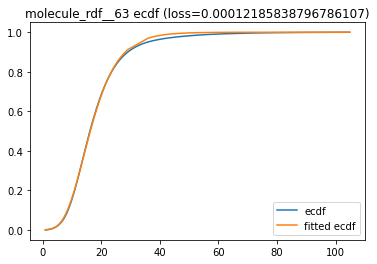

reg molecule_rdf__64
0.0020000000949949026 4.258212016976991 32.7869987487793
31 tensor(0.0043, grad_fn=<MseLossBackward>)

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


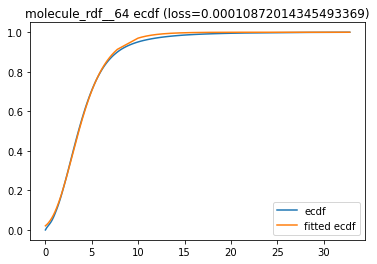

reg molecule_rdf__65
0.006000000052154064 5.335064930465136 42.89699935913086


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


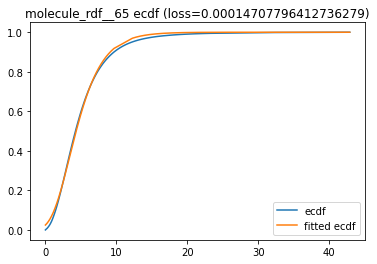

reg molecule_rdf__66
0.0 4.938829305512577 47.474998474121094


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


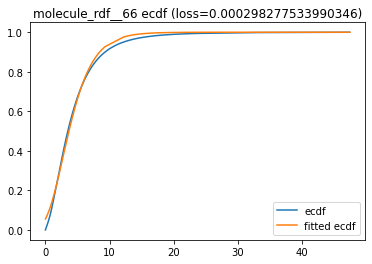

reg molecule_rdf__67
0.0 7.79154652770884 78.16600036621094


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


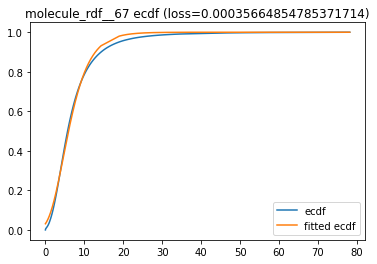

reg molecule_rdf__68
0.0 8.994355614831179 91.39299774169922


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


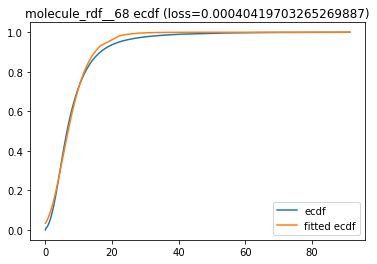

reg molecule_rdf__69
0.0 6.670823024453506 90.94499969482422


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


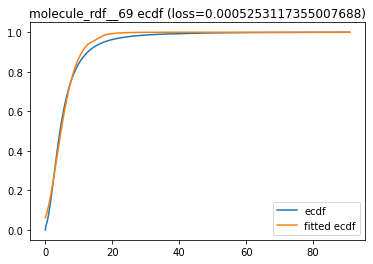

reg molecule_rdf__70
0.0 7.254633996801016 103.4219970703125


/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in power
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log2


In [ ]:
#glf_params=pd.DataFrame(columns=["Q","B","M","v","loss"])
PRINT=False
il=len(glf_params)
for i,f in enumerate(data_files[:]):
    #print(i,"/",len(data_files))
    name = os.path.basename(f).rsplit(".",1)[0]
    #print(name, end =" ")
    if (name in glf_params.index and not PRINT) or "fingerprint" in name:
    #    print()
        continue
    print(name , end=" ")
    #if name == "molecule_fr_benzene":
    #if name == "molecule_num_valence_electrons":
    data = np.load(f)
    print(data.shape)
    if np.all(data==0):
        if name in glf_params.index:
            glf_params.drop(name,inplace=True)
        continue
    if len(data.shape)>2:
        continue
        
    if np.array(data.shape[1:]).max()>1:
        if data.shape[1]>280:
            continue
        for i in range(data.shape[1]):
            nnname="{}__{}".format(name,i)
            if nnname in glf_params.index and not PRINT:
            #    print()
                continue
            try:
                glf_params = generate_ecdf(data[:,i],nnname,glf_params,plot=True)
            except Exception as e:
                continue
    else:
        #print(name)
        #generate_histo(data,name)
        glf_params = generate_ecdf(data,name,glf_params,plot=True)
    #        break
    if len(glf_params)%10==0:
        if len(glf_params)>il:
            print(len(glf_params))
            glf_params.to_csv(GLF_PARAMS_FILE)
glf_params.to_csv(GLF_PARAMS_FILE)

In [304]:
glf_params.to_csv(GLF_PARAMS_FILE+"2")
glf_params.to_csv(GLF_PARAMS_FILE)

In [303]:
len(glf_params)

1283

In [222]:
glf_params.drop(glf_params[glf_params["loss"]>9e-2].index,inplace=True)

In [301]:
glf_params[glf_params["loss"]>9e-2]

,Q,B,M,v,loss
molecule_vsa_e_state9,1.118647,0.098413,-3.843453e-01,0.871472,0.119067
molecule_ipc,0.998450,0.000732,2.855750e+06,1.001595,0.134295
molecule_get_usrcat__50,1.090004,7.868217,-3.372672e-01,0.063177,0.112875
molecule_get_usrcat__53,1.117794,8.114290,-3.272181e-01,0.067855,0.104633
molecule_get_usrcat__56,1.173677,8.992347,-2.879931e-01,0.082035,0.100987
molecule_get_usrcat__59,1.091252,7.968922,-3.332726e-01,0.063447,0.107757


In [279]:
for f in data_files:
    name = os.path.basename(f).rsplit(".",1)[0]
    if "whim" in name:
        data = np.load(f)
        for i in range(data.shape[1]):
            print(i,np.nanmax(data[:,i]))

0 604.983
1 302.779
2 44.443
3 1.0
4 0.5
5 1.0
6 1.0
7 1.0
8 0.994
9 0.999
10 2.5680839e+33
11 605.477
12 298.181
13 44.443
14 1.0
15 0.5
16 1.0
17 1.0
18 1.0
19 3.343
20 2.963
21 2.9878012e+32
22 603.854
23 306.839
24 44.443
25 1.0
26 0.5
27 1.0
28 1.0
29 1.0
30 3.899
31 1.203
32 5.1441403e+32
33 605.444
34 298.248
35 44.443
36 1.0
37 0.5
38 1.0
39 1.0
40 1.0
41 0.996
42 1.002
43 3.9315203e+31
44 603.38
45 310.633
46 44.443
47 1.0
48 0.5
49 1.0
50 1.0
51 1.0
52 1.866
53 1.597
54 5.2067193e+32
55 606.478
56 299.864
57 44.443
58 1.0
59 0.5
60 1.0
61 1.0
62 1.0
63 1.005
64 1.008
65 5.371707e+31
66 603.5
67 290.256
68 43.755
69 1.0
70 0.5
71 1.0
72 1.0
73 1.0
74 2.401
75 2.288
76 3.1283213e+30
77 687.507
78 688.519
79 686.609
80 688.504
81 685.766
82 688.149
83 694.537
84 116722.73
85 116634.8
86 116756.49
87 116636.45
88 116750.4
89 116673.08
90 117633.234
91 1.0
92 1.0
93 1.0
94 1.0
95 1.0
96 1.0
97 1.0
98 1.0
99 1.0
100 8.5602795e+32
101 9.959338e+31
102 1.7147135e+32
103 1.3105068e+31